In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import dice_ml
from dice_ml.utils import helpers # helper functions
from dice_ml import Data,Model,Dice
import numpy as np
from xgboost import XGBClassifier
import time
import threading
from joblib import Parallel, delayed
import os
import numpy as np
from dataLoader import DataLoader
from plotter import Plotter
import seaborn as sns
import pandas as pd



Load Data

In [9]:
from dataLoader import DataLoader

dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
df_cvd = dataLoader.load_data()
if df_cvd is not None:
    df_filtered_iqr = dataLoader.remove_outliers_iqr(df_cvd)
    df_filtered_std = dataLoader.remove_outliers_std(df_cvd)
    df_filtered_anomaly = dataLoader.remove_outliers_anomaly(df_cvd)

Data loaded successfully.


c:\Users\praskulkarni\Documents\cvd_counterfactual_pipeline\dataLoader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = iso_forest.fit_predict(df[columns])
c:\Users\praskulkarni\Documents\cvd_counterfactual_pipeline\dataLoader.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = iso_forest.fit_predict(df[columns])


Create Plotting object

In [10]:
plotter = Plotter(df_filtered_iqr)

Box Plots

C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\650747674.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cvd, y=col_name, x='target', ax=ax, palette='pastel')
C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\650747674.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Low Risk', 'High Risk'])
C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\650747674.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cvd, y=col_name, x='target', ax=ax, palette='pastel')
C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\650747674.py:24: UserWarnin

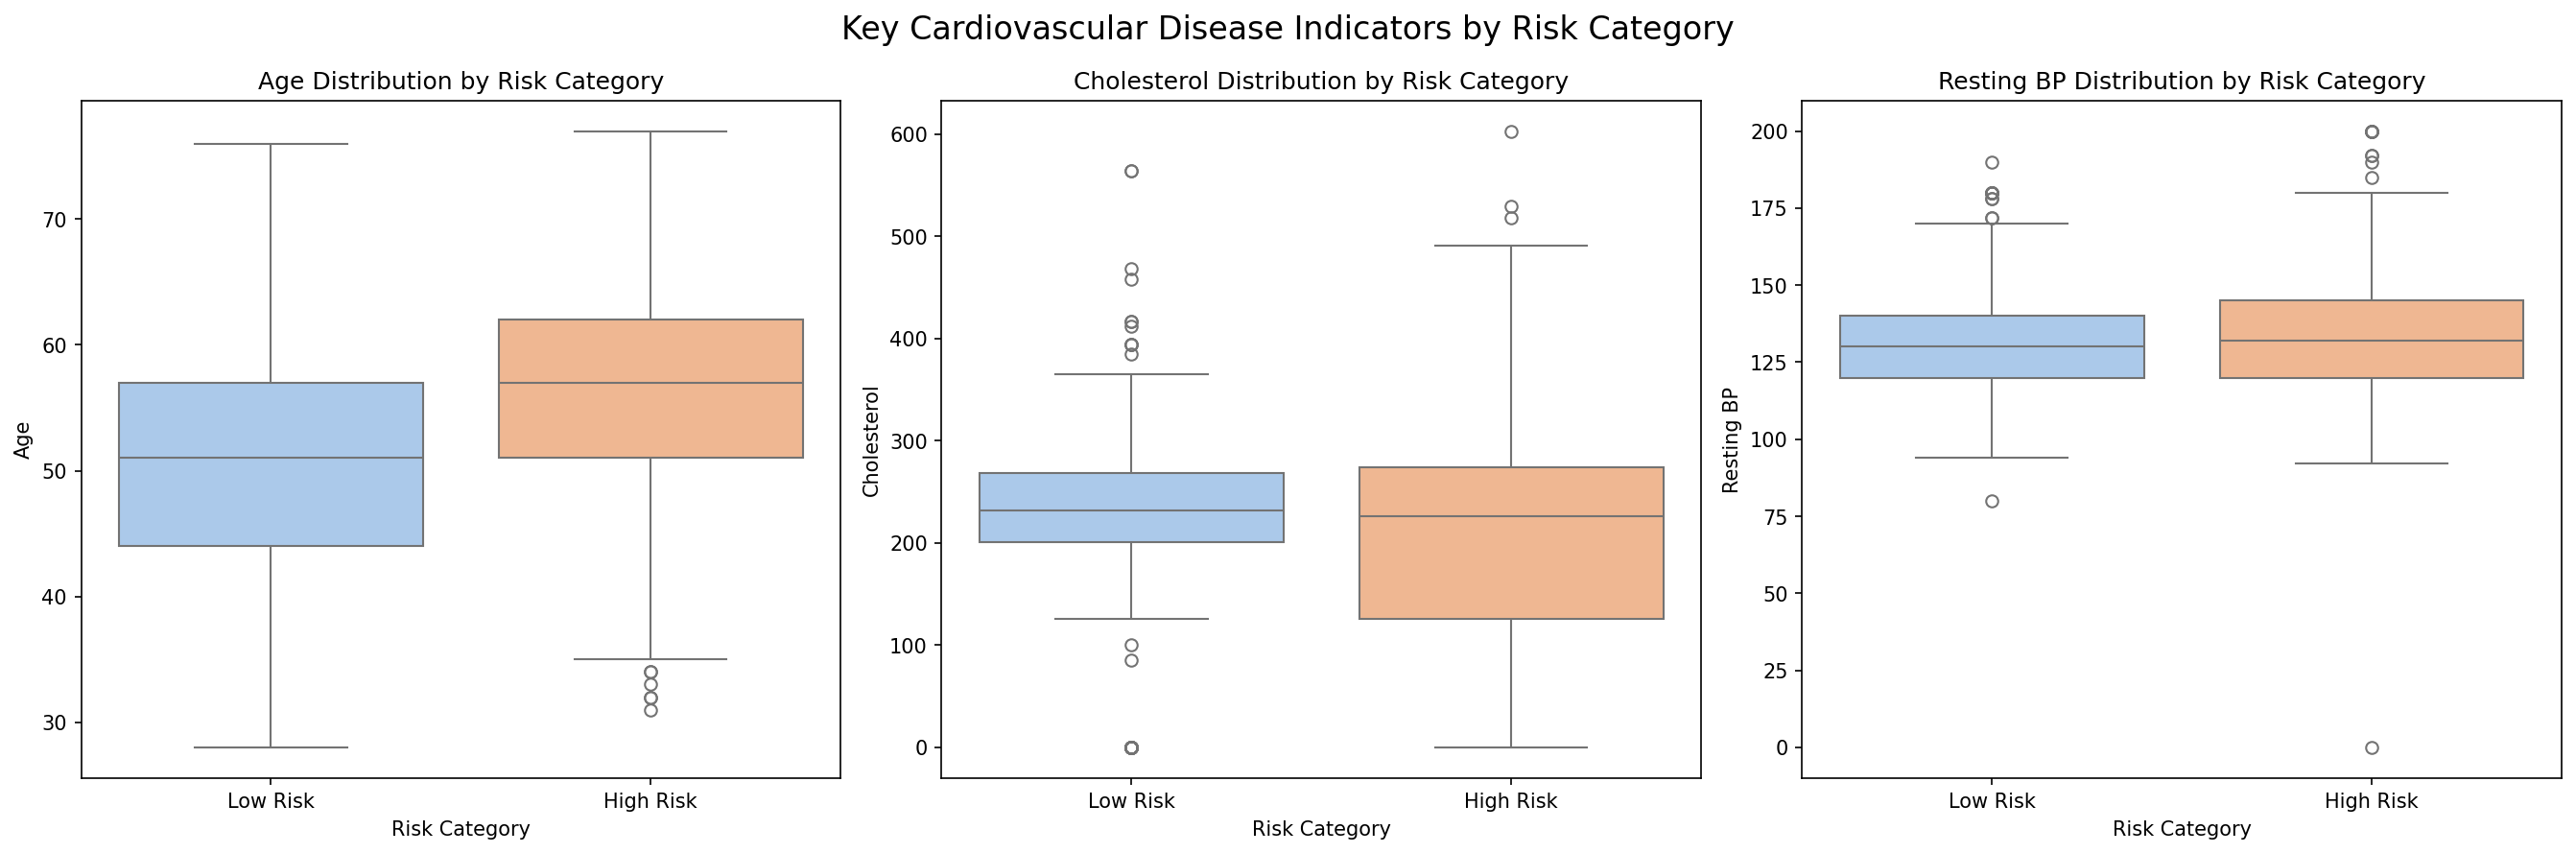

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data if not already loaded
# If running in a separate script, uncomment these lines
# dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
# df_cvd = dataLoader.load_data()

# Select columns to plot
columns = ['age', 'chol', 'trestbps']
column_labels = ['Age', 'Cholesterol', 'Resting BP']

# Set up the figure - one row, three columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Key Cardiovascular Disease Indicators by Risk Category', fontsize=16)

# Create a boxplot for each column
for i, (col_name, col_label, ax) in enumerate(zip(columns, column_labels, axes)):
    # Create the boxplot
    sns.boxplot(data=df_cvd, y=col_name, x='target', ax=ax, palette='pastel')
    
    # Replace numeric target labels with meaningful ones
    ax.set_xticklabels(['Low Risk', 'High Risk'])
    ax.set_xlabel('Risk Category')
    ax.set_ylabel(col_label)
    ax.set_title(f'{col_label} Distribution by Risk Category')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Make room for the suptitle
plt.savefig('key_cvd_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

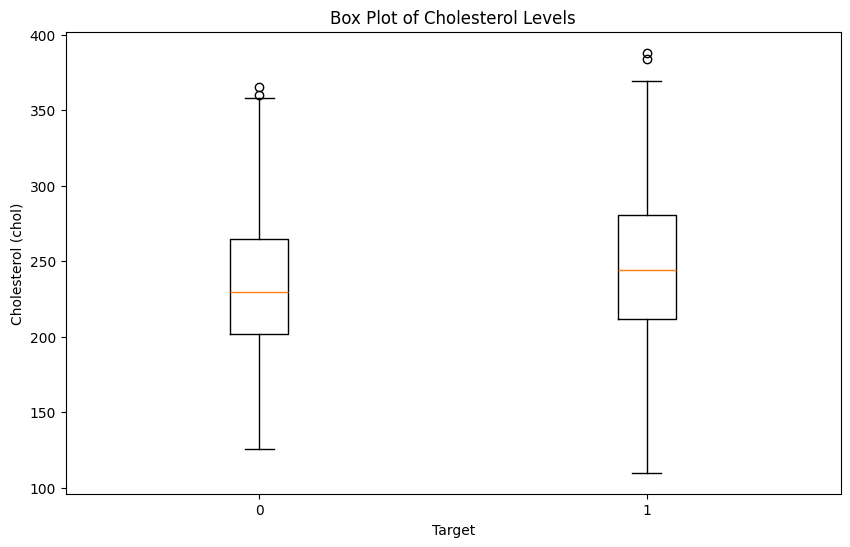

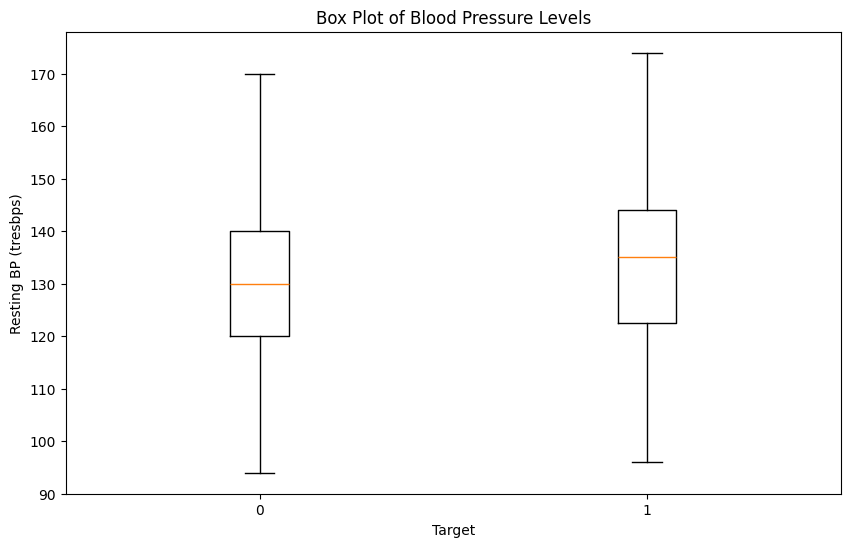

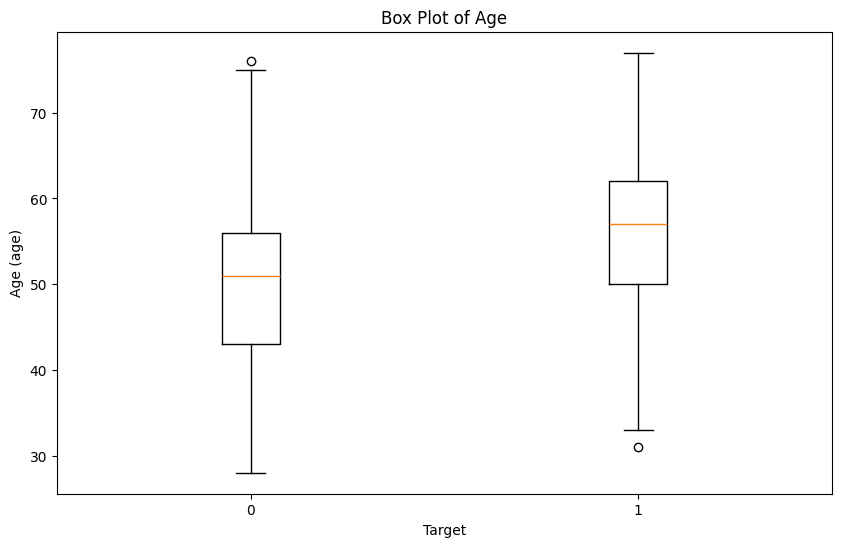

In [11]:
plotter.box_plot(target_column='target', value_column='chol', target_labels=[0, 1], title="Box Plot of Cholesterol Levels", xlabel="Target", ylabel="Cholesterol (chol)")
plotter.box_plot(target_column='target', value_column='trestbps', target_labels=[0, 1], title="Box Plot of Blood Pressure Levels", xlabel="Target", ylabel="Resting BP (tresbps)")
plotter.box_plot(target_column='target', value_column='age', target_labels=[0, 1], title="Box Plot of Age", xlabel="Target", ylabel="Age (age)")
#plotter.percentile_plot(value_column='age', target_column='target', title="Percentile Plot of Age with respect to Target", xlabel="Percentile", ylabel="Age")
#plotter.cross_tab_plot(col1='fbs', col2='target', title="Bar Plot of Fasting Blood Sugar with respect to Target", xlabel="Fasting Blood Sugar (fbs)", ylabel="Count")

Data loaded successfully.


C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\115093537.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\115093537.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Low Risk', 'High Risk'])
C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\115093537.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_12000\115093537.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

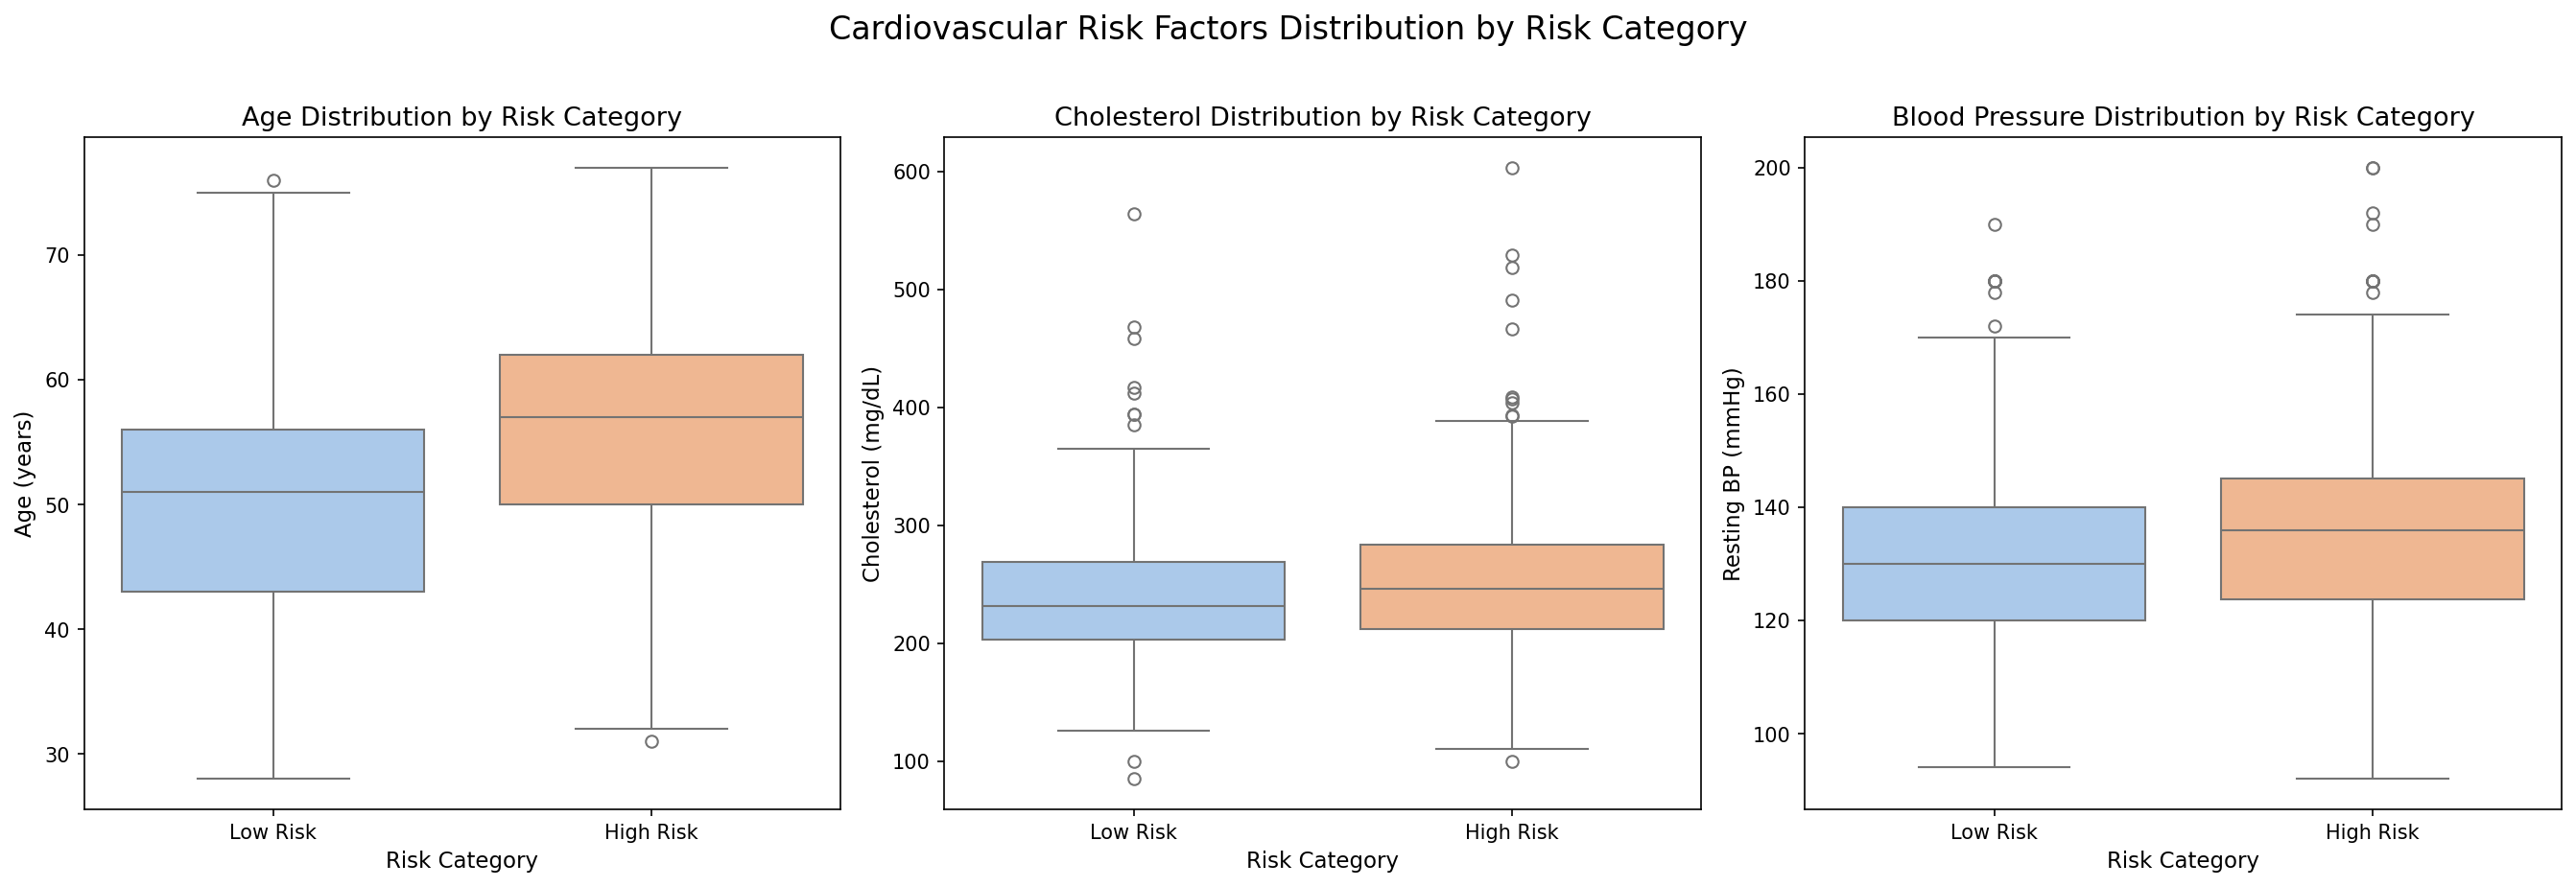

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_combined_box_plots(df, columns=['age', 'chol', 'trestbps'], 
                            titles=["Box Plot of Age", 
                                  "Box Plot of Cholesterol", 
                                  "Box Plot of Blood Pressure"],
                            ylabels=["Age", "Cholesterol (mg/dL)", "Blood Pressure (mmHg)"]):
    """
    Creates a combined figure with box plots for specified columns,
    grouped by target variable (assumed to be binary 0/1).
    """
    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)
    
    # Define risk labels and colors for consistent styling
    risk_labels = {0: 'Low Risk', 1: 'High Risk'}
    
    # Create each plot
    for i, (col, title, ylabel) in enumerate(zip(columns, titles, ylabels)):
        ax = axes[i]
        
        # Create boxplot
        sns.boxplot(
            data=df, 
            y=col, 
            x='target', 
            ax=ax, 
            palette='pastel'
        )
        
        # Replace numeric target labels with meaningful ones
        ax.set_xticklabels(['Low Risk', 'High Risk'])
        
        # Customize plot
        ax.set_title(title, fontsize=13)
        ax.set_xlabel("Risk Category", fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
    
    plt.suptitle("Cardiovascular Risk Factors Distribution by Risk Category", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('cvd_box_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load the data from your dataset
# Assuming the dataLoader object was created earlier in the notebook
dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
df_cvd = dataLoader.load_data()

# Create the combined box plots
create_combined_box_plots(
    df_cvd,
    columns=['age', 'chol', 'trestbps'],
    titles=["Age Distribution by Risk Category", 
           "Cholesterol Distribution by Risk Category",
           "Blood Pressure Distribution by Risk Category"],
    ylabels=["Age (years)", "Cholesterol (mg/dL)", "Resting BP (mmHg)"]
)

Percentile Plots

Data loaded successfully.


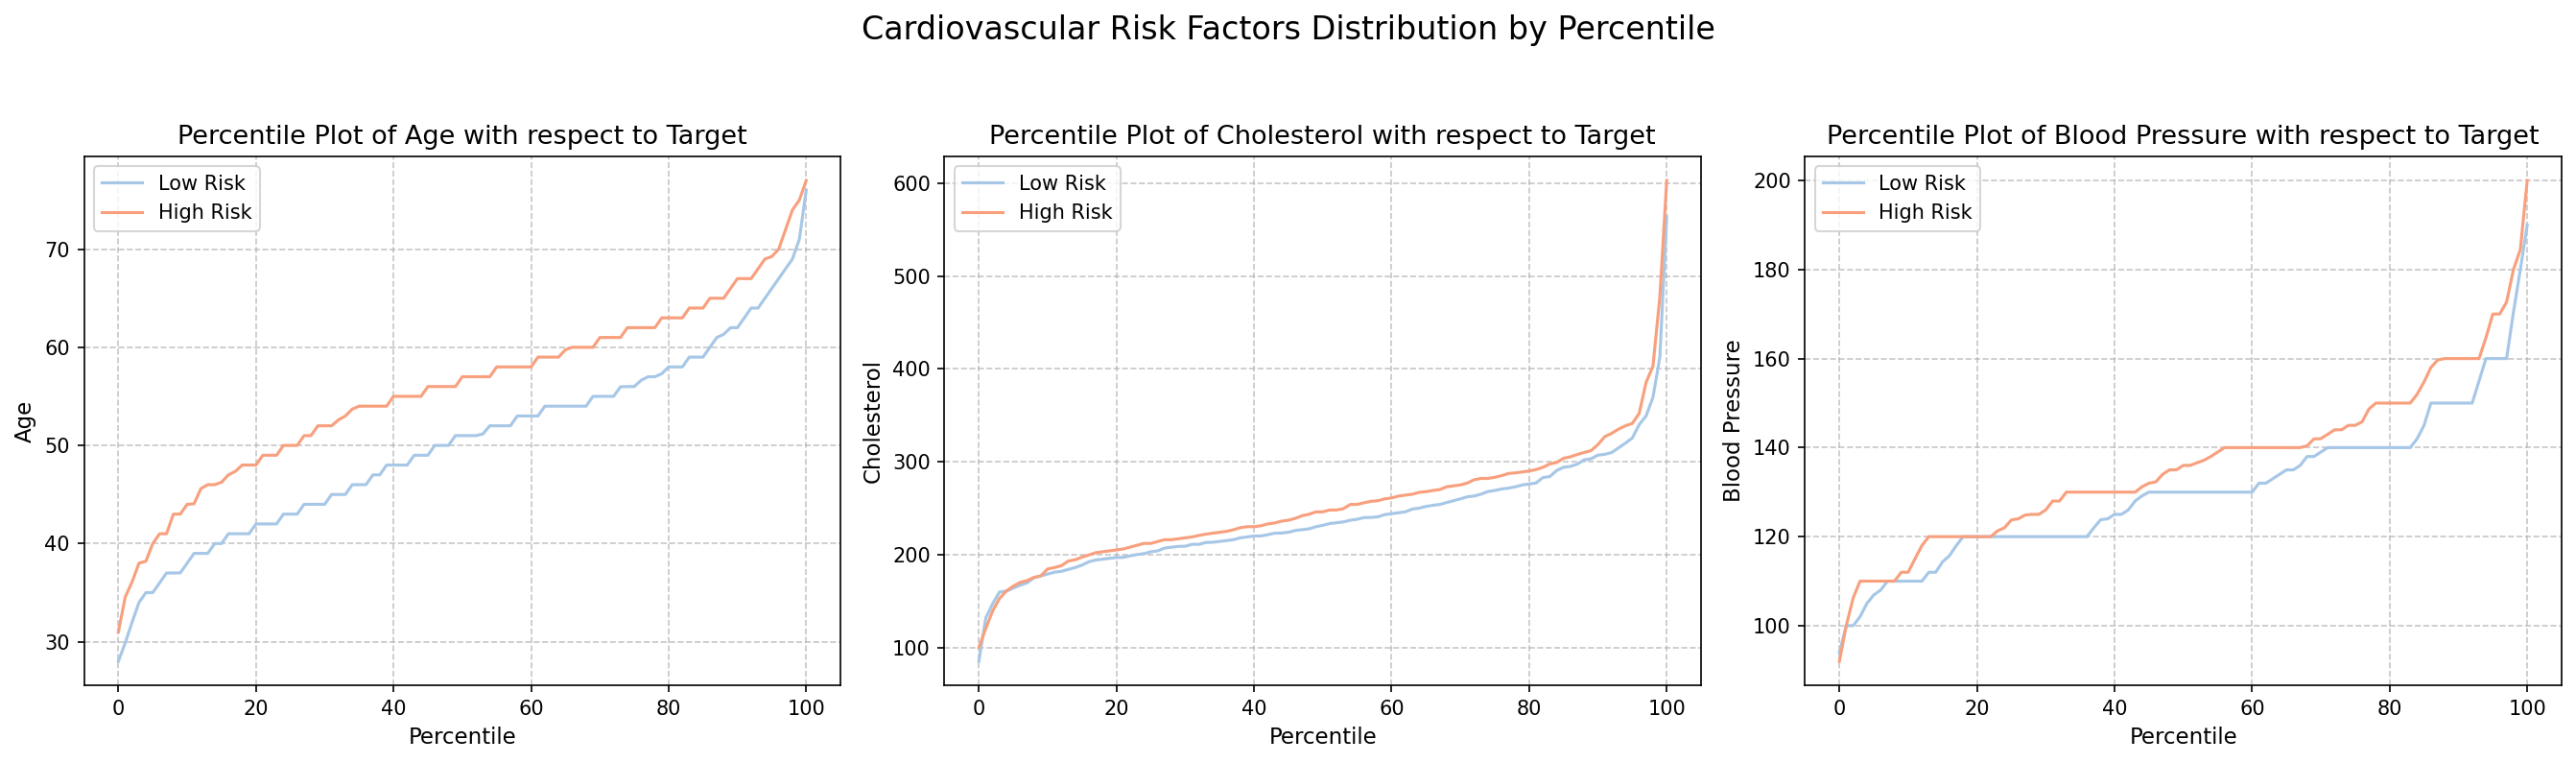

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def create_combined_percentile_plots(df, columns=['age', 'chol', 'trestbps'], 
                                   titles=["Percentile Plot of Age", 
                                          "Percentile Plot of Cholesterol", 
                                          "Percentile Plot of Blood Pressure"],
                                   ylabels=["Age", "Cholesterol", "Blood Pressure"]):
    """
    Creates a combined figure with percentile plots for specified columns,
    grouped by target variable (assumed to be binary 0/1).
    """
    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.subplots_adjust(wspace=0.3)
    
    # Define risk labels and colors for consistent styling
    risk_labels = {0: 'Low Risk', 1: 'High Risk'}
    colors = ['#a7c7e7', '#f8a07e']  # Pastel blue for low risk, soft orange for high risk
    
    # Generate percentiles
    percentiles = np.linspace(0, 100, 101)
    
    # Create each plot
    for i, (col, title, ylabel) in enumerate(zip(columns, titles, ylabels)):
        ax = axes[i]
        
        # Plot each target group
        for target_val in sorted(df['target'].unique()):
            # Filter data for current target
            target_data = df[df['target'] == target_val][col]
            
            # Calculate percentile values
            perc_values = np.percentile(target_data, percentiles)
            
            # Plot with appropriate label and color
            ax.plot(percentiles, perc_values, label=risk_labels[target_val], color=colors[target_val])
        
        # Customize plot
        ax.set_title(title, fontsize=13)
        ax.set_xlabel("Percentile", fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=10)
    
    plt.suptitle("Cardiovascular Risk Factors Distribution by Percentile", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.savefig('cvd_percentile_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load the data from your dataset
# Assuming the dataLoader object was created earlier in the notebook
dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
df_cvd = dataLoader.load_data()

# Create the combined percentile plots
create_combined_percentile_plots(
    df_cvd,
    columns=['age', 'chol', 'trestbps'],
    titles=["Percentile Plot of Age with respect to Target", 
           "Percentile Plot of Cholesterol with respect to Target",
           "Percentile Plot of Blood Pressure with respect to Target"],
    ylabels=["Age", "Cholesterol", "Blood Pressure"]
)

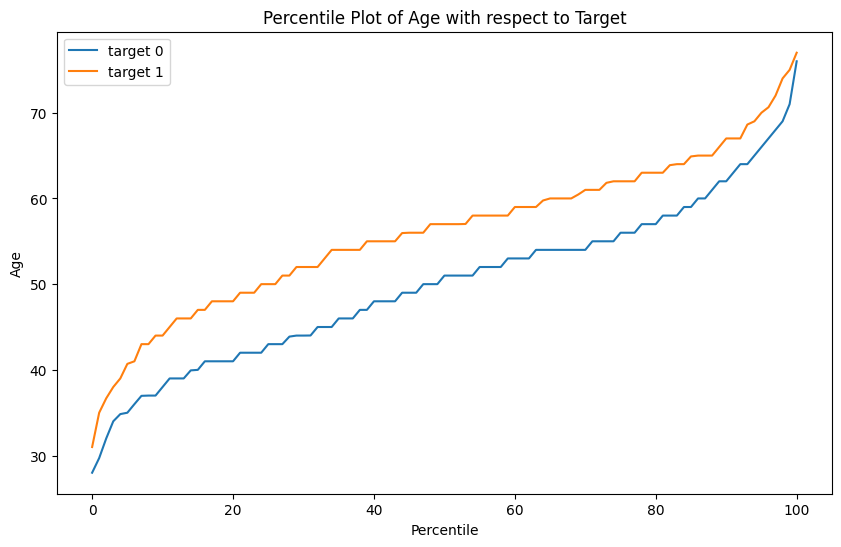

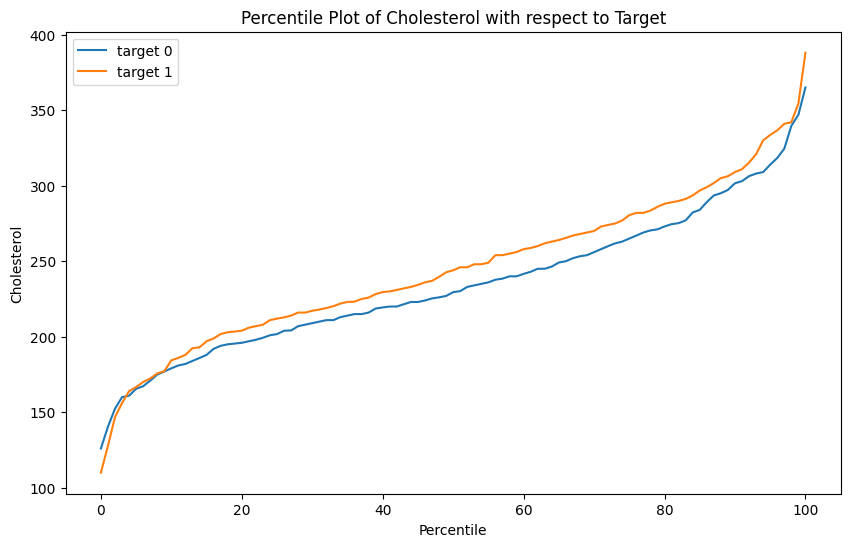

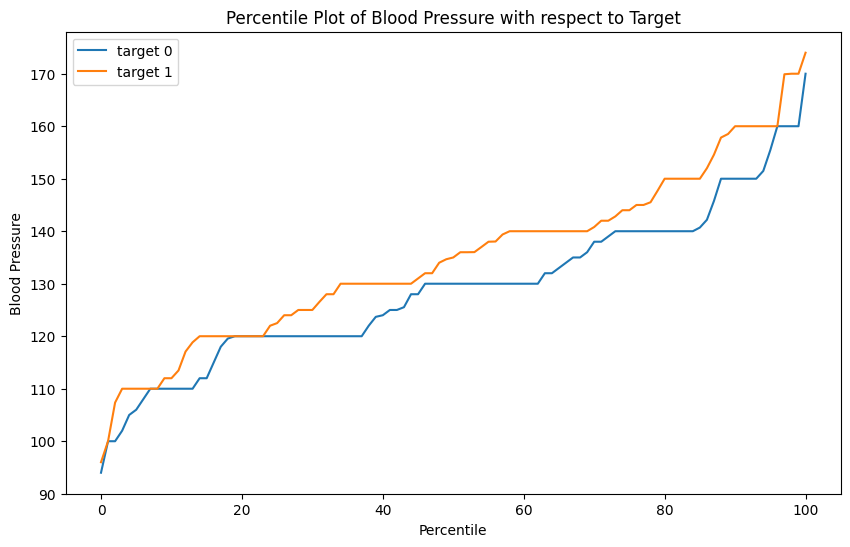

In [12]:
plotter.percentile_plot(value_column='age', target_column='target', title="Percentile Plot of Age with respect to Target", xlabel="Percentile", ylabel="Age")
plotter.percentile_plot(value_column='chol', target_column='target', title="Percentile Plot of Cholesterol with respect to Target", xlabel="Percentile", ylabel="Cholesterol")
plotter.percentile_plot(value_column='trestbps', target_column='target', title="Percentile Plot of Blood Pressure with respect to Target", xlabel="Percentile", ylabel="Blood Pressure")

Cross Tab Plots

In [41]:
import matplotlib.pyplot as plt

# Set DPI for better resolution
plt.rcParams['figure.dpi'] = 150

# Create a copy of the dataframe with mapped labels
df_plot = df_cvd.copy()
df_plot['sex_label'] = df_plot['sex'].map({0: 'Female', 1: 'Male'})
df_plot['risk_label'] = df_plot['target'].map({0: 'Low Risk', 1: 'High Risk'})
df_plot['fbs_label'] = df_plot['fbs'].map({0: 'Normal', 1: 'High'})



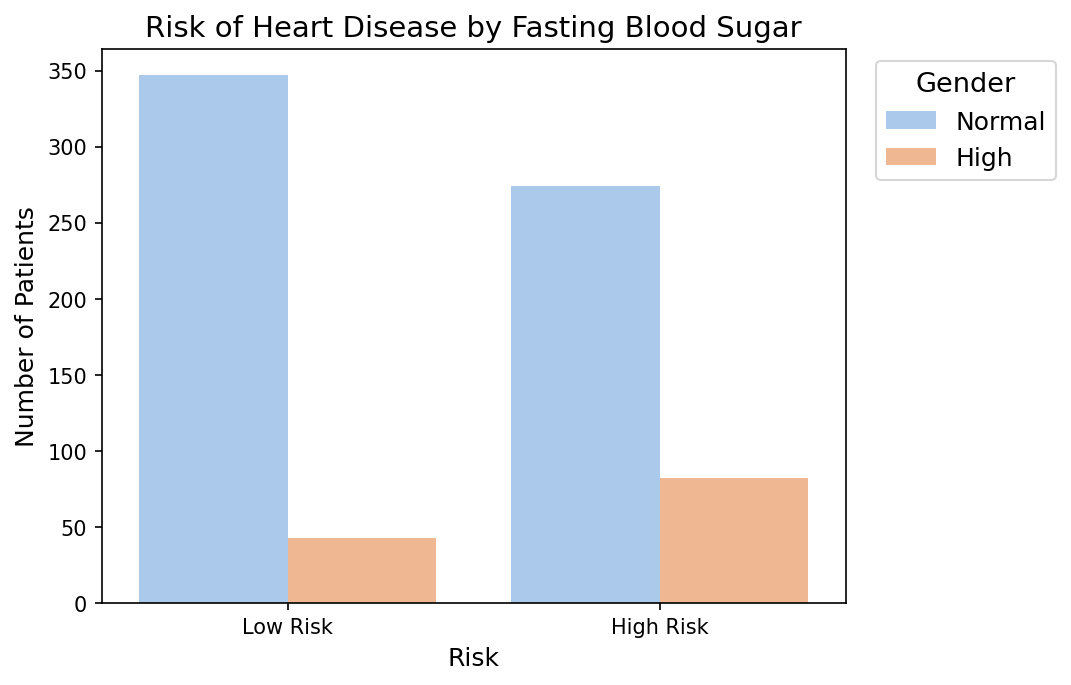

In [ ]:
import matplotlib.pyplot as plt

# Set DPI for better resolution
plt.rcParams['figure.dpi'] = 150

# Set the color palette
#sns.set_palette('pastel')

# Create a count plot of target vs fbs
sns.countplot(data=df_plot, x='risk_label', hue='sex_label', palette='pastel')

# Add a title and axis labels to the plot with increased font size
plt.title('Risk of Heart Disease by Fasting Blood Sugar', fontsize=14)
plt.xlabel('Risk', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

# Add a legend with a title and increased font size
plt.legend(title='Gender', loc='upper right', bbox_to_anchor=(1.3, 1), title_fontsize='13', fontsize='12')

plt.show()

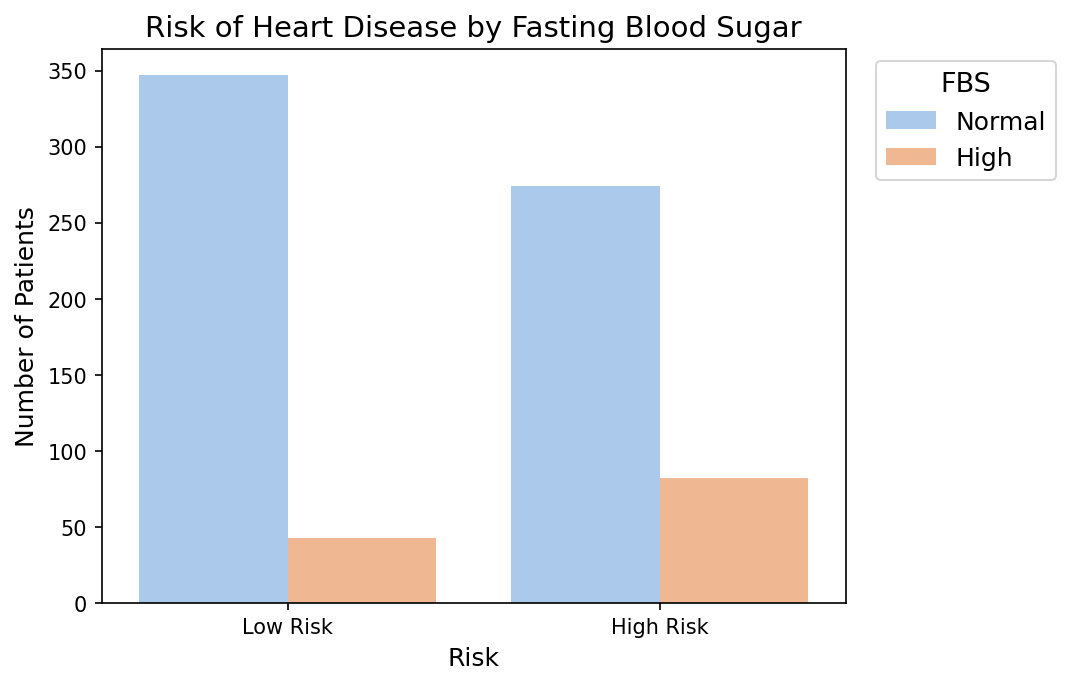

In [29]:
import matplotlib.pyplot as plt

# Set DPI for better resolution
plt.rcParams['figure.dpi'] = 150

# Set the color palette
#sns.set_palette('pastel')

# Create a count plot of target vs fbs
sns.countplot(data=df_plot, x='risk_label', hue='fbs_label', palette='pastel')

# Add a title and axis labels to the plot with increased font size
plt.title('Risk of Heart Disease by Fasting Blood Sugar', fontsize=14)
plt.xlabel('Risk', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

# Add a legend with a title and increased font size
plt.legend(title='FBS', loc='upper right', bbox_to_anchor=(1.3, 1), title_fontsize='13', fontsize='12')

plt.show()

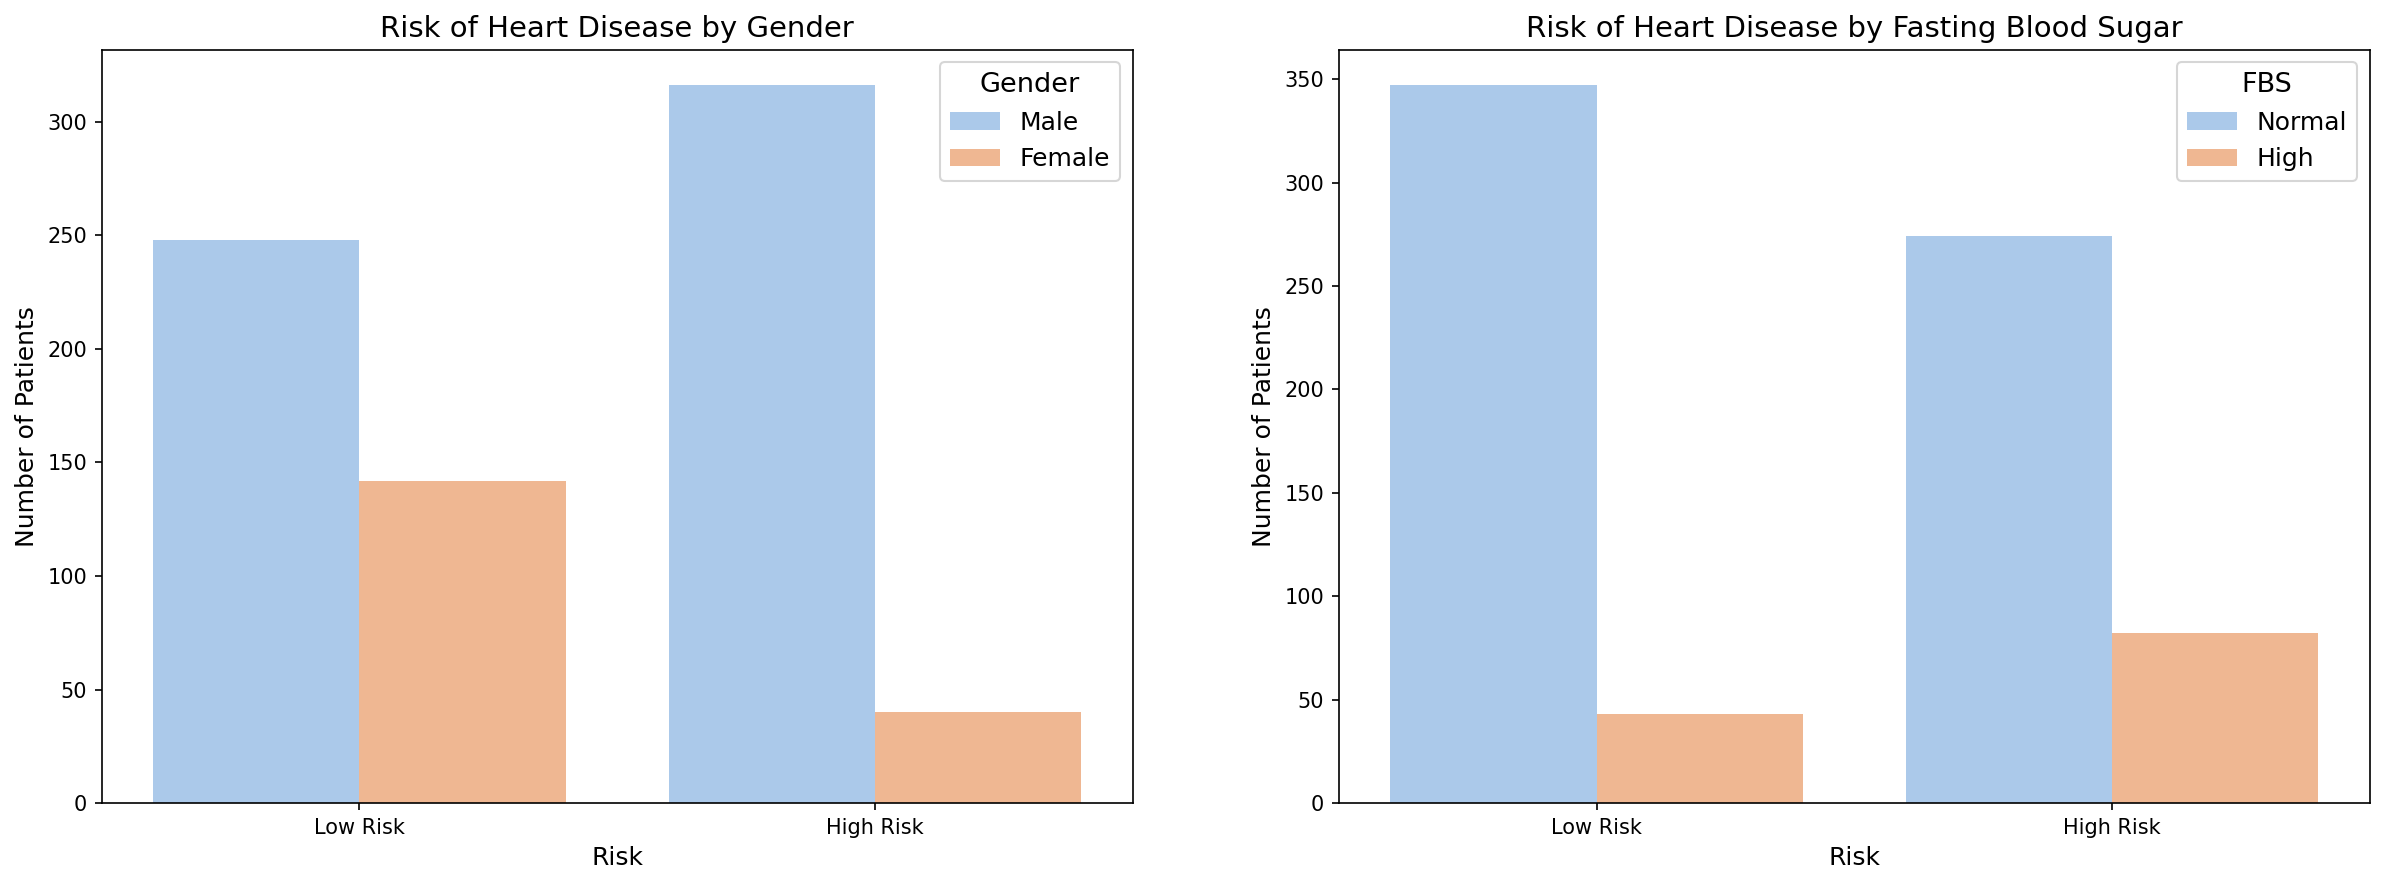

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set DPI for better resolution
plt.rcParams['figure.dpi'] = 150

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Risk by Gender
sns.countplot(data=df_plot, x='risk_label', hue='sex_label', palette='pastel', ax=axes[0])
axes[0].set_title('Risk of Heart Disease by Gender', fontsize=14)
axes[0].set_xlabel('Risk', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].legend(title='Gender', loc='upper right', title_fontsize='13', fontsize='12')

# Second subplot: Risk by Fasting Blood Sugar
sns.countplot(data=df_plot, x='risk_label', hue='fbs_label', palette='pastel', ax=axes[1])
axes[1].set_title('Risk of Heart Disease by Fasting Blood Sugar', fontsize=14)
axes[1].set_xlabel('Risk', fontsize=12)
axes[1].set_ylabel('Number of Patients', fontsize=12)
axes[1].legend(title='FBS', loc='upper right', title_fontsize='13', fontsize='12')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust the space between subplots

# Show the plot
plt.show()

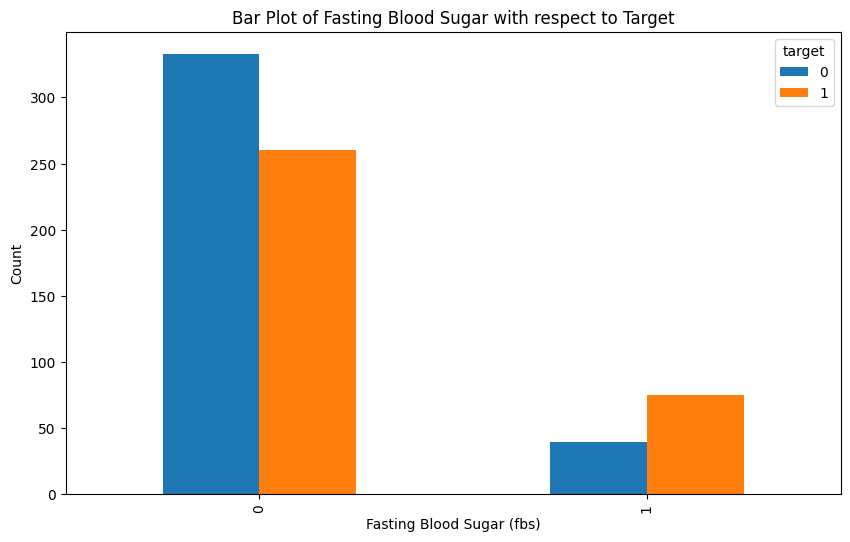

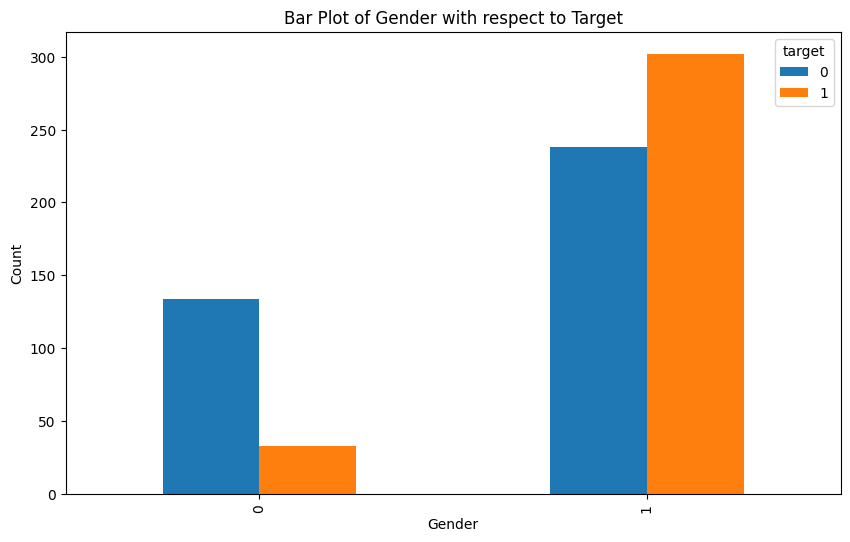

In [33]:
plotter.cross_tab_plot(col1='fbs', col2='target', title="Bar Plot of Fasting Blood Sugar with respect to Target", xlabel="Fasting Blood Sugar (fbs)", ylabel="Count")
plotter.cross_tab_plot(col1='sex', col2='target', title="Bar Plot of Gender with respect to Target", xlabel="Gender", ylabel="Count")

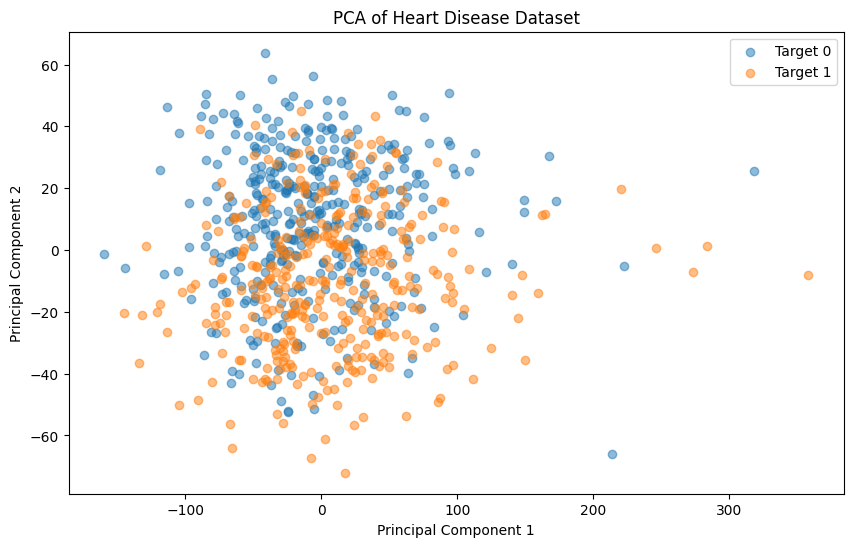

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming df_cvd is your DataFrame and 'target' is the label column
features = df_cvd.drop(columns=['target'])
target = df_cvd['target']

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[target == 0, 0], pca_result[target == 0, 1], label='Target 0', alpha=0.5)
plt.scatter(pca_result[target == 1, 0], pca_result[target == 1, 1], label='Target 1', alpha=0.5)
plt.title('PCA of Heart Disease Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

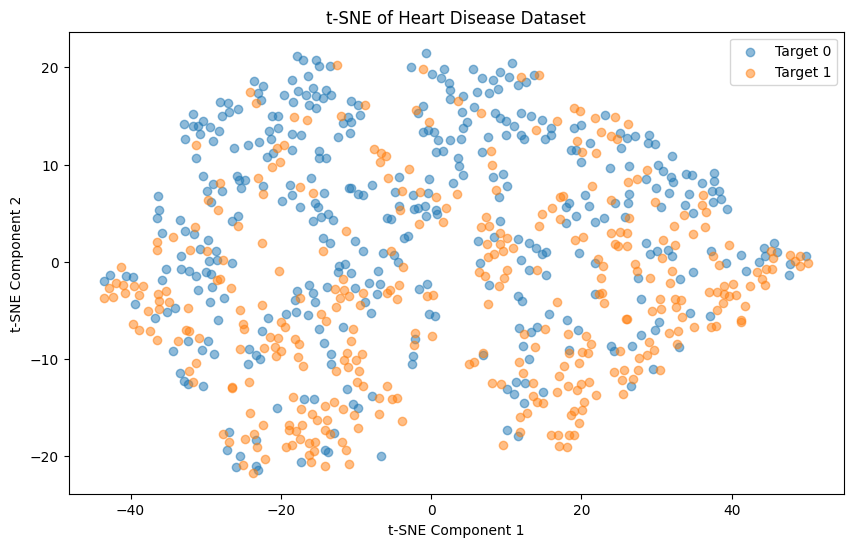

In [35]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming df_cvd is your DataFrame and 'target' is the label column
features = df_cvd.drop(columns=['target'])
target = df_cvd['target']

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[target == 0, 0], tsne_result[target == 0, 1], label='Target 0', alpha=0.5)
plt.scatter(tsne_result[target == 1, 0], tsne_result[target == 1, 1], label='Target 1', alpha=0.5)
plt.title('t-SNE of Heart Disease Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

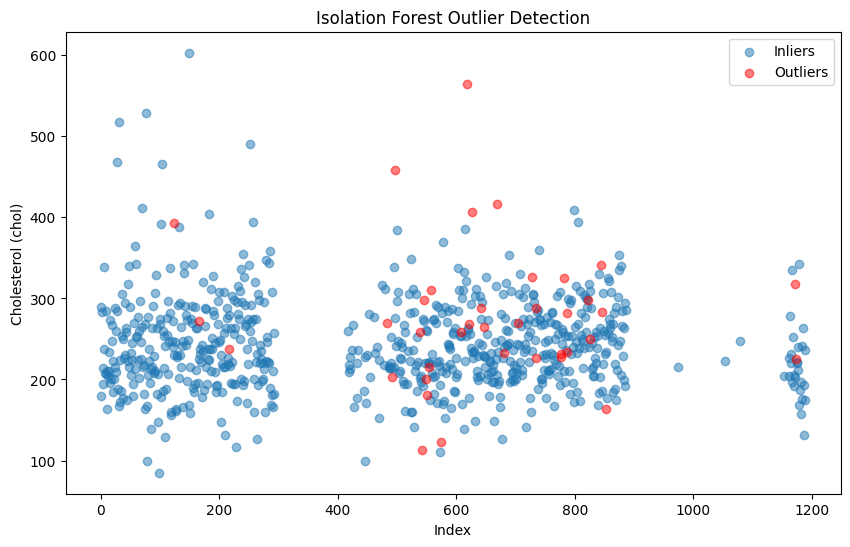

In [36]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Assuming df_cvd is your DataFrame
# Prepare the data (excluding the target column)
features = df_cvd.drop(columns=['target'])

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(features)

# Predict outliers
outliers = iso_forest.predict(features)

# Add the outlier information to the DataFrame
df_cvd['outlier'] = outliers

# Visualize the outliers
plt.figure(figsize=(10, 6))
plt.scatter(df_cvd[df_cvd['outlier'] == 1].index, df_cvd[df_cvd['outlier'] == 1]['chol'], label='Inliers', alpha=0.5)
plt.scatter(df_cvd[df_cvd['outlier'] == -1].index, df_cvd[df_cvd['outlier'] == -1]['chol'], label='Outliers', alpha=0.5, color='r')
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Index')
plt.ylabel('Cholesterol (chol)')
plt.legend()
plt.show()

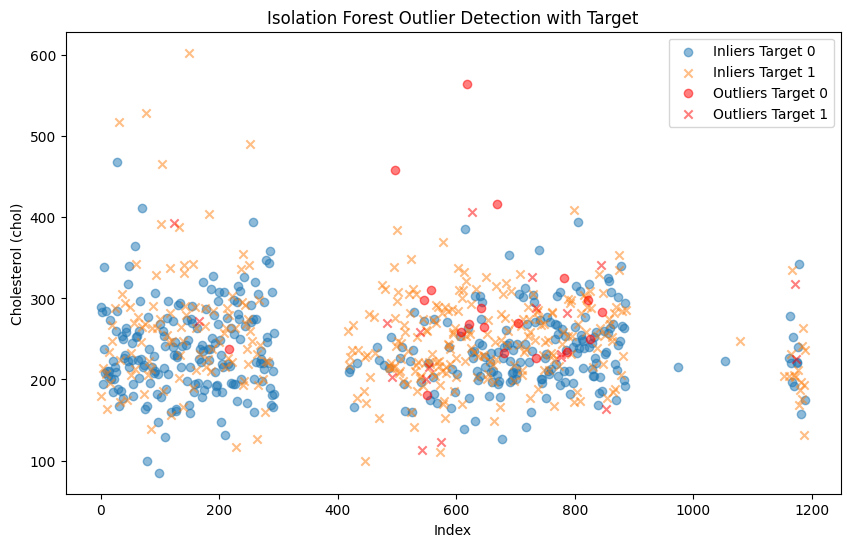

In [37]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Assuming df_cvd is your DataFrame
# Prepare the data (excluding the target column)
features = df_cvd.drop(columns=['target'])

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(features)

# Predict outliers
outliers = iso_forest.predict(features)

# Add the outlier information to the DataFrame
df_cvd['outlier'] = outliers

# Visualize the outliers with target
plt.figure(figsize=(10, 6))

# Inliers with target 0
plt.scatter(df_cvd[(df_cvd['outlier'] == 1) & (df_cvd['target'] == 0)].index, 
            df_cvd[(df_cvd['outlier'] == 1) & (df_cvd['target'] == 0)]['chol'], 
            label='Inliers Target 0', alpha=0.5, marker='o')

# Inliers with target 1
plt.scatter(df_cvd[(df_cvd['outlier'] == 1) & (df_cvd['target'] == 1)].index, 
            df_cvd[(df_cvd['outlier'] == 1) & (df_cvd['target'] == 1)]['chol'], 
            label='Inliers Target 1', alpha=0.5, marker='x')

# Outliers with target 0
plt.scatter(df_cvd[(df_cvd['outlier'] == -1) & (df_cvd['target'] == 0)].index, 
            df_cvd[(df_cvd['outlier'] == -1) & (df_cvd['target'] == 0)]['chol'], 
            label='Outliers Target 0', alpha=0.5, color='r', marker='o')

# Outliers with target 1
plt.scatter(df_cvd[(df_cvd['outlier'] == -1) & (df_cvd['target'] == 1)].index, 
            df_cvd[(df_cvd['outlier'] == -1) & (df_cvd['target'] == 1)]['chol'], 
            label='Outliers Target 1', alpha=0.5, color='r', marker='x')

plt.title('Isolation Forest Outlier Detection with Target')
plt.xlabel('Index')
plt.ylabel('Cholesterol (chol)')
plt.legend()
plt.show()

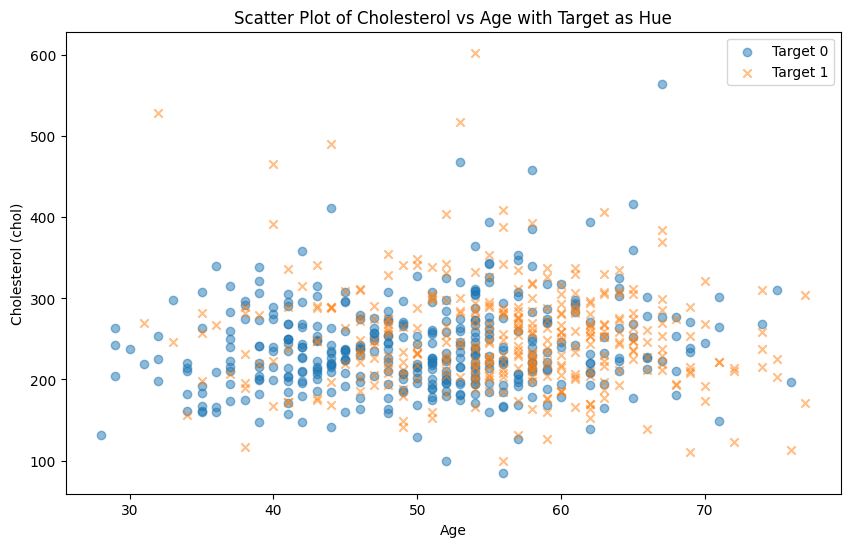

In [38]:
import matplotlib.pyplot as plt

# Assuming df_cvd is your DataFrame
# Create the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for target 0
plt.scatter(df_cvd[df_cvd['target'] == 0]['age'], 
            df_cvd[df_cvd['target'] == 0]['chol'], 
            label='Target 0', alpha=0.5, marker='o')

# Scatter plot for target 1
plt.scatter(df_cvd[df_cvd['target'] == 1]['age'], 
            df_cvd[df_cvd['target'] == 1]['chol'], 
            label='Target 1', alpha=0.5, marker='x')

plt.title('Scatter Plot of Cholesterol vs Age with Target as Hue')
plt.xlabel('Age')
plt.ylabel('Cholesterol (chol)')
plt.legend()
plt.show()

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)


# Create a DICE data object
d = Data(dataframe=pd.DataFrame(train_data, columns=df_cvd.columns), continuous_features=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],outcome_name='target')

# Create a DICE model object
m = Model(model=xgb_pipeline, backend="sklearn")

Ideal Countefactuals

In [ ]:
import threading
import queue

df_no_counterfactuals = pd.DataFrame(columns=X_high_risk_tp.columns)
def generate_cf(test_instance, timeout=10):
    q = queue.Queue()

    def target():
        try:
            result = Dice(d, m, method='genetic').generate_counterfactuals(test_instance, total_CFs=3, desired_class="opposite",
                                                                           features_to_vary=["trestbps", "chol", "thalach"],
                                                                           #diversity_weight=5, proximity_weight=2, sparsity_weight=5,
                                                                           permitted_range={"trestbps": [80, 120], "chol": [150, 200], "thalach": [120, 220 - test_instance['age'].values[0]]}
                                                                           )
            q.put(result)
        except Exception as e:
            print("No counterfactuals found for test instance:", test_instance)
            df_no_counterfactuals.append(test_instance)
            q.put(None)

    # Start a new thread to run the target function
    thread = threading.Thread(target=target)
    thread.start()

    # Wait for the thread to finish or raise a timeout exception
    thread.join(timeout)

    if thread.is_alive():
        # The thread is still running, so raise a timeout exception
        print("No counterfactuals found for test instance-timed out:", test_instance)
        df_no_counterfactuals.append(test_instance)
        q.put(None)
    else:
        # The thread has finished, so return the result
        return q.get()

In [ ]:

exps_ideal = []
num_cores = -1

# Iterate over each instance of X_high_risk and generate counterfactuals
for i in range(len(X_high_risk_tp)):
    test_instance = X_high_risk_tp.iloc[[i]]
    print(i)
    exp = Parallel(n_jobs=num_cores)(delayed(generate_cf)(test_instance) for i in range(1))
    exps_ideal.append(exp)

In [ ]:
num_none = sum(exp[0] is None for exp in exps_ideal)
print("Number of None values in exps_ideal:", num_none)

In [ ]:
print((96-18)/96)

In [ ]:
validity_list = []
for exps in exps_ideal:
    
    if exps[0] is not None:
       exp_df = exps[0].cf_examples_list[0].final_cfs_df
       validity_list.append(xgb_pipeline.predict(exp_df)[0])

In [ ]:
mean_values_list = []
median_values_list = []
std_values_list = []

for exps in exps_ideal:
    if exps[0] is not None:
        exp_df = exps[0].cf_examples_list[0].final_cfs_df

        # Calculate the mean
        mean_values = exp_df[['chol', 'trestbps', 'thalach']].mean()
        mean_values_list.append(mean_values)

        # Calculate the median
        median_values = exp_df[['chol', 'trestbps', 'thalach']].median()
        median_values_list.append(median_values)

        # Calculate the standard deviation
        std_values = exp_df[['chol', 'trestbps', 'thalach']].std()
        std_values_list.append(std_values)

# Convert lists to DataFrames
mean_values_df = pd.DataFrame(mean_values_list)
median_values_df = pd.DataFrame(median_values_list)
std_values_df = pd.DataFrame(std_values_list)

# Calculate and print the mean of means, median of medians, and std dev of std devs
print('Mean of means:\n', mean_values_df.mean())
print('\nMedian of medians:\n', median_values_df.median())
print('\nStandard deviation of standard deviations:\n', std_values_df.std())

In [ ]:
import pandas as pd
import numpy as np

# Initialize an empty DataFrame
all_data_df = pd.DataFrame()

statistics = {}

for exps in exps_ideal:
    if exps[0] is not None:
        exp_df = exps[0].cf_examples_list[0].final_cfs_df
        all_data_df = pd.concat([all_data_df, exp_df[['chol', 'trestbps', 'thalach']]])


# Calculate and store the mean, median, and std dev
for column in ['chol', 'trestbps', 'thalach']:
    statistics[column] = {
        'mean': np.mean(all_data_df[column]),
        'median': np.median(all_data_df[column]),
        'std_dev': np.std(all_data_df[column])
    }

print(statistics)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert the dictionary to a DataFrame
statistics_df = pd.DataFrame(statistics)

# Create a new figure
plt.figure(figsize=(15, 5))

# Plot the mean values
plt.subplot(1, 3, 1)
statistics_df.loc['mean'].plot(kind='bar')
plt.title('Mean')
plt.ylabel('Value')

# Plot the median values
plt.subplot(1, 3, 2)
statistics_df.loc['median'].plot(kind='bar')
plt.title('Median')

# Plot the standard deviation values
plt.subplot(1, 3, 3)
statistics_df.loc['std_dev'].plot(kind='bar')
plt.title('Standard Deviation')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
exps_ideal[0][0].visualize_as_dataframe()

In [ ]:
percentage = sum(validity_list) / len(validity_list) * 100
print("Number of Valid Ideal Counterfactuals: {:.2f}%".format(100-percentage))